## Implementing the model with fishing
We add fishing in the model, targetting the predator, with an off-target effect on the prey.
We note :
- $p_1 $ and $p_2$ the fishing intensity of the preys


Assuming $p_2 < p_1 $


\begin{equation*}
\begin{cases}
\frac{dF_1}{dt} = \delta_1 (K_1 - F_1(t)) - F_1(t)N(t)uA_1(u) - p_1 F_1(t)  & \text{Density of prey in env. 1} \\
\frac{dF_2}{dt} = \delta_2 (K_2 - F_2(t)) - F_2(t)N(t)(1-u)A_2(u) - p_2 F_2(t) & \text{Density of prey in env. 2} \\ 
\frac{dN}{dt}  =  (\beta(u) - \mu) N(t) & \text{Density of fish}
\end{cases}
\end{equation*}

\begin{equation}
\beta(u) = 
\underbrace{F_1(t)}_{\text{(prey density)}}
\underbrace{A_1(u)}_{\text{(search rate)}}
\underbrace{u}_{\text{(time spent)}} + 
\underbrace{F_2(t)}_{\text{(prey density)}}
\underbrace{A_2(u)}_{\text{(search rate)}}
\underbrace{(1-u)}_{\text{(time spent)}}
\end{equation}

## Hypothesis of the adaptive dynamics
- The resident is at equilibrium ($N_r = N_r^*$)
- The mutant population is small ($N_m << N_r$)
On top of these fundamental hypothesis, we assume here that the dynamics of the prey is faster than the predator's (Quasi-Steady-State, QSS), yielding:

\begin{align*}
\frac{dF_1}{dt} = \frac{dF_2}{dt} =& 0 \\ 
\Leftrightarrow& \begin{cases}
F_1^*(N_r, N_m) = \frac{\delta_1 K_1}{\delta_1 + N_r(t)rA_1(r) + N_m(t)mA_1(m) + p_1} & = \frac{\delta_1 K_1}{\delta_1 + N_r^*rA_1(r) + p_1}\\
F_2^*(N_r, N_m) = \frac{\delta_2 K_2}{\delta_2 + N_r(t)(1-r)A_2(r) + N_m(t)(1-m)A_2(m) + p_2} & = \frac{\delta_2 K_2}{\delta_2 + N_r^*(1-r)A_2(r) + p_2}\\
\end{cases}
\end{align*}


The system becomes:

\begin{align}
\begin{cases}
\frac{dN_r}{dt} &= [\beta(r, N_r(t), N_m(t)) - \mu ] N_r(t)\\
\frac{dN_m}{dt} &= [\beta(m, N_r(t), N_m(t)) - \mu ] N_m(t)\\
\end{cases}
\end{align}

Finding $N_r^*$ is not trivial, we'll do it numerically. Nevertheless we
can have a ballpark estimation by considering that
$\delta_1<< A_1(r)N^*$, $\delta_2<< A_2(r)N^*$, and $p_1<< A_1(r)N^*$, $p_2$<<$A_2(r)N^*$:

\begin{align*}
\beta(r, N_r(t), N_m(t)) - \mu &= 0\\
\frac{\delta_1 K_1 A_1(r) r}{A_1(r)rN^*+\delta_1+p_1} + \frac{\delta_2 K_2 A_2(r) r}{A_2(r)rN^*+\delta_2+p_2} - \mu &= 0\\
\frac{\delta_1 K_1 A_1(r) r}{A_1(r)rN^*} + \frac{\delta_2 K_2 A_2(r) r}{A_2(r)rN^*}  &\approx \mu \\
N^* &\approx \frac{\delta_1 K_1 + \delta_2 K_2}{\mu}\\
\end{align*}

Our goal is to compute the invasion growth rate of a mutant (with trait
$m$) in an environment set by a resident (with trait value $r$). We
denote this quantity $s_r(m)$.

### Invasion fitness of the mutant

The invasion fitness $s_r(m)$ is given by:

\begin{align*}
s_r(m) =& \beta(m, N^*, 0) - \mu \\
=& F_1(N^*, 0)mA_1(m) + F_2(N^*, 0)(1-m)A_2(1-m)\\
\end{align*}

Numerical Pairwise invasibility plot
=============================

We want to plot the subset of $[0,1]^2$ where:

\begin{equation}
s_r(m) > 0 \;\; \text{for} \;\; m,r \in [0,1]^2
\end{equation}

You will need the following functions: 
[`scipy.optimize.fsolve`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html#scipy-optimize-fsolve),  Use the doc to
check what they are doing.


import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from functools import partial

In [3]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from functools import partial

In [14]:
p_common = { "b2":0, 'd1':0.1,'d2':0.1,'K1':1,'K2':1,'mu':0.1,}  # Values common for the three sets
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}           # Neutral set
p_strong1 = {"a1": 1, "b1": 1, "a2":2, 'p1':0, 'p2':0, **p_common}            # Strong efficiency in environment 2
p_strong2 = {"a1": 1, "b1": 1, "a2":2, 'p1':0.95, 'p2':0, **p_common}            # Strong efficiency in environment 2
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}             # Strong efficiency in environment 1

In [5]:
def A(u, a, b):
    """Attack rate. Volume of prey cleared per unit of time.
    Phenomenlogical model assuming a simple linear relationship between the time spent u
    and the attack rate."""
    return(a + b * u)

def F1_QSS(r, d1, K1, a1, b1, Nr, p1, **kwargs):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return( (d1*K1)/(A(r, a1, b1)*r*Nr + d1 + p1))
           
def F2_QSS(r, d2, K2, a2, b2, Nr,  p2, **kwargs):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return( (d2*K2)/(A(r, a2, b2)*(1-r)*Nr + d2 + p2))
                 
def beta(u, F1, F2, a1, b1, a2, b2):
    """Birth rate of a predator with trait u"""
    return (  F1 * A(u, a1, b1) * u 
            + F2 * A(u, a2, b2) * (1-u)) 

def n_star_solve(r, a1, a2, b1, b2, K1, K2, d1, d2, mu, p1, p2, **kwargs):
    """Population size of the resident at equilibrium.
    
    The equilibrium of the resident is found by finding 
    its population size N* for which its growth rate is null. 
    """
    
    def ToSolve(Nr):
        F1_star = F1_QSS(r, d1, K1, a1, b1, Nr, p1)
        F2_star = F2_QSS(r, d2, K2, a2, b2, Nr, p2)
        growth_rate =  beta(r, F1_star, F2_star, a1, b1, a2, b2) - mu
        return(growth_rate)
    # Rough estimate used to initialise the optimisation algorithm.
    estimate = (d1*K1+d2*K2)/mu
    
    return scipy.optimize.fsolve(ToSolve,x0=estimate)

In [6]:
def invasion_fitness(r,m, a1, b1, a2, b2, mu, K1, K2, d1, d2, p1, p2, **kwargs):
    n_star = n_star_solve(r, a1, a2, b1, b2, K1, K2, d1, d2, mu, p1, p2)
    F1_star = F1_QSS(r, d1, K1, a1, b1, n_star, p1)
    F2_star = F2_QSS(r, d2, K2, a2, b2, n_star, p2)
    mutant_growth_rate =  beta(m, F1_star, F2_star, a1, b1, a2, b2) - mu
    return(mutant_growth_rate)

def PIP_matrix(r_vec, m_vec, a1, b1, a2, b2, mu, K1, K2, d1, d2, p1, p2, **kwargs):
    dim1 = len(r_vec)
    dim2 = len(m_vec)
    S = np.zeros((dim1, dim2))
    for i in range (dim1):
        for j in range(dim2):
            r = r_vec[i]
            m = m_vec[j]
            s = invasion_fitness(r,m, a1, b1, a2, b2, mu, K1, K2, d1, d2, p1, p2)
            S[j,i] = s
    return(S)

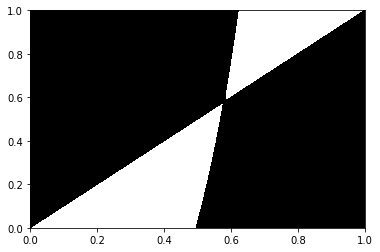

In [64]:
r_vec= m_vec = np.linspace(0,1,100)
S = PIP_matrix(r_vec, m_vec, **p_strong1)
R, M = np.meshgrid(r_vec, m_vec)
plt.contourf(R, M, S, levels=[np.min(S), 0, np.max(S)], colors=['w', 'k'])
plt.show()

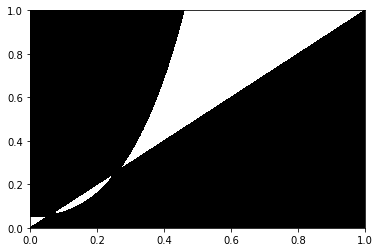

In [15]:
r_vec= m_vec = np.linspace(0,1,100)
S = PIP_matrix(r_vec, m_vec, **p_strong2)
R, M = np.meshgrid(r_vec, m_vec)
plt.contourf(R, M, S, levels=[np.min(S), 0, np.max(S)], colors=['w', 'k'])
plt.show()